# CFRM 421 Final Proejct - Terence Chiu

# Introduction

What is the goal of your project?

• What is the data that you are using? What is the original data source if known?

• What does an instance in your data represent (e.g. a person, a transaction, etc.)? How many
instances are there?

• What is the target variable you are trying to predict?

• What are the features used to predict it? Give a few examples of the features.

• Provide any additional relevant information about your data if known (e.g. what is the time
period, what place is it collected from, etc.

# Problem Setup

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


# Algorithms

DNN  
Inputs:
- Weekly Import
- Weekly Production
- Weekly Supply
- Crude Oil Futures Price 1-2 minutes before release  

Outputs (predict): 
- Futures Price 1-2 minutes after release

Model Definition

Preparing the data

Define plot method to compare predicted and actual price at T+2 minutes after weekly report release

In [55]:
import pandas as pd
import numpy as np
df = pd.read_csv("full_data.csv")

feature_cols = [col for col in df.columns if 'Close_t-60'  in col or 'Close_t-40' in col or 'Close_t-20' in col or col == 'Release Date' or col == 'Actual' or col == 'Weekly Net Import' or col == 'Weekly Production' or col == 'Open_t0']

X_temp = df[feature_cols]
y_temp = df['Close_t2']

In [56]:
feature_cols

['Release Date',
 'Close_t-60',
 'Close_t-40',
 'Close_t-20',
 'Open_t0',
 'Actual',
 'Weekly Net Import',
 'Weekly Production']

In [57]:
prod_weekly = X_temp[['Release Date', 'Weekly Production']]
net_import_weekly = X_temp[['Release Date', 'Weekly Net Import']]
supply_weekly = X_temp[['Release Date', 'Actual']]
price_wide = X_temp[['Release Date', 'Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']]

In [58]:
from sklearn.preprocessing import StandardScaler

price_scaler = StandardScaler()
target_scaler = StandardScaler()

price_features = price_wide[['Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']]

# Scale the price features in the dataframe
for col in ['Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']:
    price_features[col] = price_scaler.fit_transform(price_wide[col].values.reshape(-1, 1)).flatten()

# Scale the target values in the dataframe
y_temp = target_scaler.fit_transform(y_temp.values.reshape(-1, 1)).flatten()

/var/folders/vl/xcbt_9650nz8tknq733z87640000gn/T/ipykernel_10787/1514931792.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_features[col] = price_scaler.fit_transform(price_wide[col].values.reshape(-1, 1)).flatten()
/var/folders/vl/xcbt_9650nz8tknq733z87640000gn/T/ipykernel_10787/1514931792.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_features[col] = price_scaler.fit_transform(price_wide[col].values.reshape(-1, 1)).flatten()
/var/folders/vl/xcbt_9650nz8tknq733z87640000gn/T/ipykernel

In [67]:
#Scaler for weekly data
weekly_scaler = StandardScaler()

weekly_production_scaled = weekly_scaler.fit_transform(prod_weekly['Weekly Production'].values.reshape(-1, 1)).flatten()
weekly_import_scaled = weekly_scaler.fit_transform(net_import_weekly['Weekly Net Import'].values.reshape(-1, 1)).flatten()
weekly_supply_scaled = weekly_scaler.fit_transform(supply_weekly['Actual'].values.reshape(-1, 1)).flatten()

In [76]:
X = []
y = []

for idx, row in price_features.iterrows():
    # Target: price of future 2 minutes after release (already scaled)
    target_price = y_temp[idx]

    
    production_value = weekly_production_scaled[idx]
    import_value = weekly_import_scaled[idx]
    supply_value = weekly_supply_scaled[idx]
    production_value = production_value
    import_value = import_value
    supply_value = supply_value

    row_data = [price_features['Close_t-60'].values[idx],price_features['Close_t-40'].values[idx],price_features['Close_t-20'].values[idx],price_features['Open_t0'].values[idx],production_value,import_value,supply_value]
    X.append(row_data)
    y.append(target_price)

X = np.array(X)
y = np.array(y)

In [77]:
from terenceModel import DNN
from terenceTrainModel import plot_predictions


In [79]:
# Time-based 80/20 split
n = len(X)
split_idx = int(n * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
 

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1131 - mae: 0.9377 - val_loss: 1.0212 - val_mae: 0.8279
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5851 - mae: 0.6615 - val_loss: 0.5044 - val_mae: 0.5515
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3111 - mae: 0.4431 - val_loss: 0.2752 - val_mae: 0.3548
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1656 - mae: 0.3165 - val_loss: 0.1773 - val_mae: 0.2512
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1608 - mae: 0.3148 - val_loss: 0.1380 - val_mae: 0.2268
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1509 - mae: 0.3044 - val_loss: 0.1268 - val_mae: 0.2283
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1327 - mae: 0.2798 - val_loss: 0.1061 - val_mae: 0.2145
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1196 - mae: 0.2693 - val_loss: 0.0901 - val_mae: 0.1937
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.126

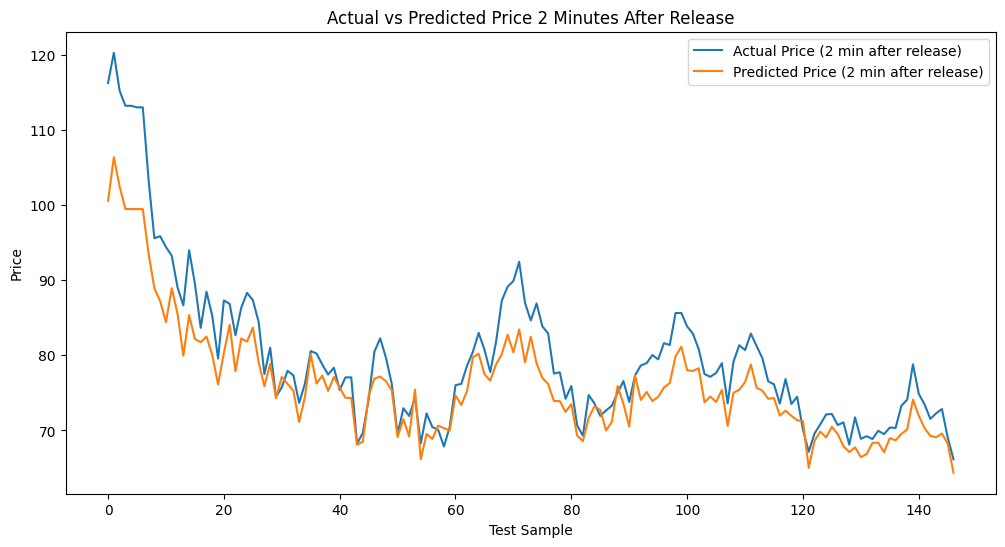

In [81]:
from matplotlib import pyplot as plt
model = DNN()
    
# Train model
trained_model, _ = model.train(X_train, y_train)

# Evaluate model
test_loss, test_mae = trained_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.2f}")
print(f'Test MAE: {test_mae:.2f}')

# Predict on test set
y_pred = trained_model.predict(X_test).flatten()

# Plot and print MAE (unscaled)
plot_predictions(y_pred, y_test, target_scaler)

# Conclusions

Test MAE (unscaled) between predicted and actual prices after two minutes of weekly report release is 1.25

This model predicts the price given momentum of price the hour before report release, and THE report